<a href="https://colab.research.google.com/github/ikwak2/hmd/blob/main/notebooks/rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset: https://physionet.org/content/circor-heart-sound/1.0.1/

A baseline model: https://github.com/physionetchallenges/python-classifier-2022

In [338]:
!wget -r -N -c -np https://physionet.org/files/circor-heart-sound/1.0.1/

Streaming output truncated to the last 5000 lines.
File ‘physionet.org/files/circor-heart-sound/1.0.1/training_data/85196_AV.tsv’ not modified on server. Omitting download.

--2022-03-03 00:08:57--  https://physionet.org/files/circor-heart-sound/1.0.1/training_data/85196_AV.wav
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/circor-heart-sound/1.0.1/training_data/85196_AV.wav’ not modified on server. Omitting download.

--2022-03-03 00:08:57--  https://physionet.org/files/circor-heart-sound/1.0.1/training_data/85196_MV.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 304 Not Modified
File ‘physionet.org/files/circor-heart-sound/1.0.1/training_data/85196_MV.hea’ not modified on server. Omitting download.

--2022-03-03 00:08:57--  https://physionet.org/files/circor-heart-sound/1.0.1/training_data/85196_MV.tsv
Reusing existing connection to physionet.org:443.
H

In [339]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import joblib
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
!pip install watermark

### Import helper functions from https://github.com/physionetchallenges

In [340]:
!git clone https://github.com/physionetchallenges/python-classifier-2022.git

fatal: destination path 'python-classifier-2022' already exists and is not an empty directory.


In [341]:
import sys
sys.path.insert(0,'/content/python-classifier-2022')

## Parameters

In [376]:
root_dir = '/content/physionet.org/files/circor-heart-sound/1.0.1'
training_data_file = root_dir + '/' + 'training_data.csv'
training_data_dir = root_dir + '/' + 'training_data'
model_dir = root_dir + '/' + 'model'

## Functions

In [377]:
from helper_code import get_age, compare_strings, get_sex, compare_strings
from IPython.core.debugger import set_trace

In [378]:
# Extract features from the data.
# This is defined at originally defined at https://github.com/physionetchallenges/python-classifier-2022/blob/29fdf49efe82b2fff20f0bb685ba71ba858e3171/team_code.py#L136 
# We need to modify this accordingly
def get_features(data, recordings):
    # Extract the age group and replace with the (approximate) number of months for the middle of the age group.
    age_group = get_age(data)

    if compare_strings(age_group, 'Neonate'):
        age = 0.5
    elif compare_strings(age_group, 'Infant'):
        age = 6
    elif compare_strings(age_group, 'Child'):
        age = 6 * 12
    elif compare_strings(age_group, 'Adolescent'):
        age = 15 * 12
    elif compare_strings(age_group, 'Young Adult'):
        age = 20 * 12
    else:
        age = float('nan')

    # Extract sex. Use one-hot encoding.
    sex = get_sex(data)

    sex_features = np.zeros(2, dtype=int)
    if compare_strings(sex, 'Female'):
        sex_features[0] = 1
    elif compare_strings(sex, 'Male'):
        sex_features[1] = 1

    # Extract height and weight.
    height = get_height(data)
    weight = get_weight(data)

    # Extract pregnancy status.
    is_pregnant = get_pregnancy_status(data)

    # Extract recording locations and data. Identify when a location is present, and compute the mean, variance, and skewness of
    # each recording. If there are multiple recordings for one location, then extract features from the last recording.
    locations = get_locations(data)

    recording_locations = ['AV', 'MV', 'PV', 'TV', 'PhC']
    num_recording_locations = len(recording_locations)
    recording_features = np.zeros((num_recording_locations, 4), dtype=float)
    num_locations = len(locations)
    num_recordings = len(recordings)
    if num_locations==num_recordings:
        for i in range(num_locations):
            for j in range(num_recording_locations):
                if compare_strings(locations[i], recording_locations[j]) and np.size(recordings[i])>0:
                    recording_features[j, 0] = 1
                    recording_features[j, 1] = np.mean(recordings[i])
                    recording_features[j, 2] = np.var(recordings[i])
                    recording_features[j, 3] = sp.stats.skew(recordings[i])

    recording_features = recording_features.flatten()

    features = np.hstack(([age], sex_features, [height], [weight], [is_pregnant], recording_features))

    return np.asarray(features, dtype=np.float32)

## Exploring the meta data

In [379]:
os.listdir(root_dir)

['training_data',
 'LICENSE.txt',
 'index.html',
 'training_data.csv',
 'model',
 'RECORDS',
 'SHA256SUMS.txt']

In [380]:
df = pd.read_csv(training_data_file)
df

,Patient ID,Locations,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,Systolic murmur timing,Systolic murmur shape,Systolic murmur grading,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.9,False,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,Holosystolic,Diamond,III/VI,High,Harsh,NaN,NaN,NaN,NaN,NaN,CC2015,NaN
2,9983,AV+PV+TV+MV,Child,Male,115.0,19.1,False,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.9,False,Present,TV,TV,Holosystolic,Plateau,I/VI,Low,Blowing,NaN,NaN,NaN,NaN,NaN,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.2,False,Present,AV+MV+PV+TV,PV,Early-systolic,Plateau,II/VI,Low,Harsh,NaN,NaN,NaN,NaN,NaN,CC2015,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,85340,AV+PV+TV+MV,Child,Male,105.0,16.6,False,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC2015,NaN
938,85341,AV+PV+TV+MV,Child,Male,92.0,15.2,False,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC2015,NaN
939,85343,AV+PV+TV+MV,Child,Female,97.0,13.5,False,Present,MV+TV,TV,Early-systolic,Plateau,I/VI,Low,Blowing,NaN,NaN,NaN,NaN,NaN,CC2015,NaN
940,85345,AV+PV,Child,Female,132.0,38.1,False,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC2015,NaN


In [381]:
df.describe()

,Patient ID,Height,Weight,Additional ID
count,942.000000,826.000000,837.000000,140.000000
mean,66624.319533,110.800242,23.632756,58208.735714
std,16966.858912,30.000607,15.453337,10216.094378
min,2530.000000,35.000000,2.300000,23625.000000
25%,50263.250000,89.000000,12.500000,50092.000000
50%,68452.500000,115.000000,20.400000,50661.500000
75%,84938.500000,133.000000,31.200000,68466.250000
max,85349.000000,180.000000,110.800000,85234.000000


In [382]:
df.columns

Index(['Patient ID', 'Locations', 'Age', 'Sex', 'Height', 'Weight',
       'Pregnancy status', 'Murmur', 'Murmur locations',
       'Most audible location', 'Systolic murmur timing',
       'Systolic murmur shape', 'Systolic murmur grading',
       'Systolic murmur pitch', 'Systolic murmur quality',
       'Diastolic murmur timing', 'Diastolic murmur shape',
       'Diastolic murmur grading', 'Diastolic murmur pitch',
       'Diastolic murmur quality', 'Campaign', 'Additional ID'],
      dtype='object')

In [383]:
# summary of NA's in each column
df.isnull().sum()

Patient ID                    0
Locations                     0
Age                          74
Sex                           0
Height                      116
Weight                      105
Pregnancy status              0
Murmur                        0
Murmur locations            763
Most audible location       763
Systolic murmur timing      764
Systolic murmur shape       764
Systolic murmur grading     764
Systolic murmur pitch       764
Systolic murmur quality     764
Diastolic murmur timing     937
Diastolic murmur shape      937
Diastolic murmur grading    937
Diastolic murmur pitch      937
Diastolic murmur quality    937
Campaign                      0
Additional ID               802
dtype: int64

In [384]:
df.shape

(942, 22)

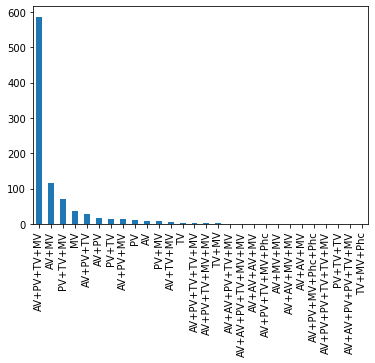

In [385]:
df['Locations'].value_counts().plot.bar()

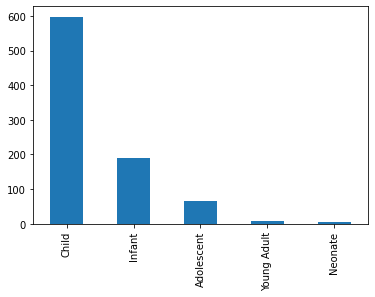

In [386]:
df['Age'].value_counts().plot.bar()

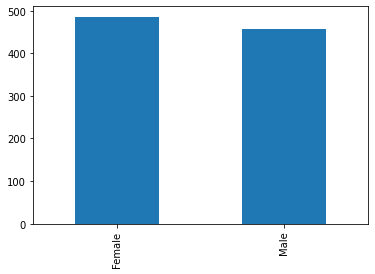

In [387]:
df['Sex'].value_counts().plot.bar()

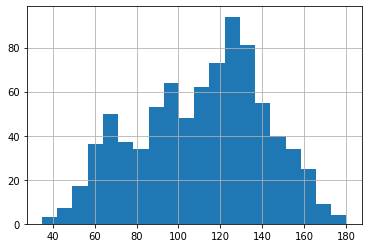

In [388]:
df['Height'].hist(bins = 20)

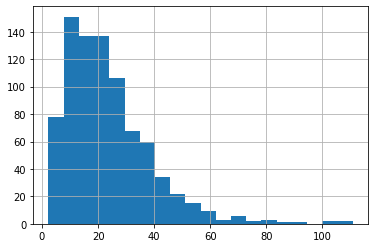

In [389]:
df['Weight'].hist(bins = 20)

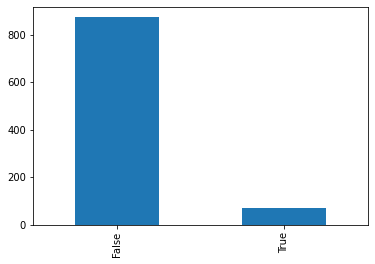

In [390]:
df['Pregnancy status'].value_counts().plot.bar()

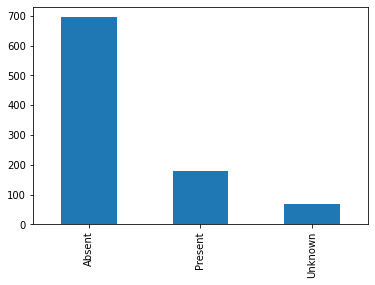

In [391]:
df['Murmur'].value_counts().plot.bar()

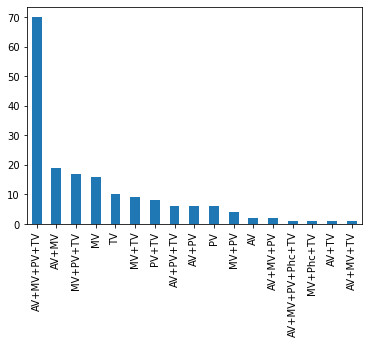

In [392]:
df['Murmur locations'].value_counts().plot.bar()

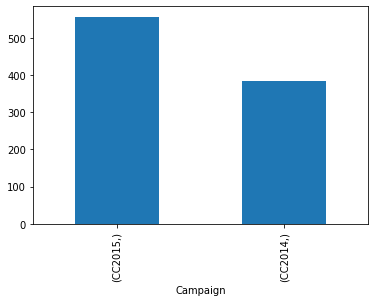

In [393]:
df[['Campaign']].value_counts().plot.bar()

## Prepare features

In [394]:
patient_files = find_patient_files(training_data_dir)
num_patient_files = len(patient_files)

In [395]:
print(f'Number of patient files: {num_patient_files}')

Number of patient files: 942


In [396]:
# Create a folder for the model if it does not already exist.
os.makedirs(model_dir, exist_ok=True)

In [397]:
classes = ['Present', 'Unknown', 'Absent']
num_classes = len(classes)

In [398]:
features = list()
labels = list()
for i in range(num_patient_files):
  print(f'reading {patient_files[i]}')
  current_patient_data = load_patient_data(patient_files[i])
  current_recordings = load_recordings(training_data_dir, current_patient_data) # returns a list of arrays
  current_features = get_features(current_patient_data, current_recordings) # 
  features.append(current_features)
  current_labels = np.zeros(num_classes, dtype=int)
  label = get_label(current_patient_data)
  if label in classes:
    j = classes.index(label)
    current_labels[j] = 1
  labels.append(current_labels)

reading /content/physionet.org/files/circor-heart-sound/1.0.1/training_data/2530.txt
reading /content/physionet.org/files/circor-heart-sound/1.0.1/training_data/9979.txt
reading /content/physionet.org/files/circor-heart-sound/1.0.1/training_data/9983.txt
reading /content/physionet.org/files/circor-heart-sound/1.0.1/training_data/13918.txt
reading /content/physionet.org/files/circor-heart-sound/1.0.1/training_data/14241.txt
reading /content/physionet.org/files/circor-heart-sound/1.0.1/training_data/14998.txt
reading /content/physionet.org/files/circor-heart-sound/1.0.1/training_data/23625.txt
reading /content/physionet.org/files/circor-heart-sound/1.0.1/training_data/24160.txt
reading /content/physionet.org/files/circor-heart-sound/1.0.1/training_data/29045.txt
reading /content/physionet.org/files/circor-heart-sound/1.0.1/training_data/29378.txt
reading /content/physionet.org/files/circor-heart-sound/1.0.1/training_data/31737.txt
reading /content/physionet.org/files/circor-heart-sound/1

In [399]:
features = np.vstack(features)
labels = np.vstack(labels)

## Train a random forest classifier

This model only takes the meta data features and does not use any wave features, 

In [400]:
n_estimators = 10    # Number of trees in the forest.
max_leaf_nodes = 100 # Maximum number of leaf nodes in each tree.
random_state = 123   # Random state; set for reproducibility.
cv = 10

imputer = SimpleImputer().fit(features)
features = imputer.transform(features)
model = RandomForestClassifier(n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, random_state=random_state)
res = cross_val_score(model, features, labels, cv = cv)

In [401]:
print(f'accuracy of {cv} fold CV: {np.mean(res)}')

accuracy of 10 fold CV: 0.6933482642777155


## Watermark

In [402]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [403]:
%watermark -iv -v

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

scipy        : 1.4.1
tensorflow   : 2.8.0
pandas       : 1.3.5
joblib       : 1.1.0
numpy        : 1.21.5
sys          : 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
IPython      : 5.5.0
tensorflow_io: 0.24.0

